In [1]:
'''
This script runs a model, then plots the pilot v3 data and the model optimal predictions on the same plots 

First, pickles in data and calculates mean reaction time, movement time (right now doesn't use data bc reaction times aren't
accurate becasue it's easier to track the agent than it is to do the two-choice reaction time task)

Second, runs simulation 

Third, Plots

'''

"\nThis script runs a model, then plots the pilot v3 data and the model optimal predictions on the same plots \n\nFirst, pickles in data and calculates mean reaction time, movement time (right now doesn't use data bc reaction times aren't\naccurate becasue it's easier to track the agent than it is to do the two-choice reaction time task)\n\nSecond, runs simulation \n\nThird, Plots\n\n"

In [2]:
import numpy as np 
import scipy 
from scipy.stats import norm
from scipy.stats import skewnorm
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.pyplot import cm
import os
import random
from tqdm import tqdm
import numba as nb
from numba import njit
from numba import jit
import matplotlib.animation as animation
from textwrap import wrap
import data_visualization as dv
import pickle

In [3]:
# Initial thangs
os.chdir('D:\\Subject_Data\\Seth_MatchPennies_Agent_Pilot_v3')
PATH = os.getcwd()
save_path = 'C:\\Users\\Seth Sullivan\\OneDrive - University of Delaware - o365\\Desktop\\MatchPennies-Agent-Expirement\\Data Figures\\'
# if not os.path.exists(PATH+save_path):
#         os.makedirs(PATH+save_path)

with open(PATH+"\\Analysis_Pull_List.txt","r") as pull_file:
    analysis_pull_list = pull_file.read().splitlines()
with open(PATH+"\\Fields_Pull.txt","r") as fields_pull:
    fields_pull = fields_pull.read().splitlines()  
# SPECIFIC TO EXPERIMENT   
reaction_trials = 50    
timing_trials = 50
num_trials = 100 #number of trials in each block 
num_blocks = 6
tot_trials = num_trials*num_blocks
data_columns = len(fields_pull)
trial_time = 1500
num_subjects = len(analysis_pull_list)
wheel = dv.ColorWheel()

plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.titleweight"] = "bold"

In [4]:
tp3_title = "1000,50"
tp4_title = "1000,150"
tp5_title = '1100,50'
tp6_title = "1100,150"
tp7_title = "1200,50"
tp8_title = '1200,150'
tp9_title = '1300,100'
tp10_title = '1300,200'
trial_block_titles = [tp3_title, tp4_title, tp5_title,tp6_title, tp7_title, tp8_title]

box_color1 = wheel.rak_red
box_color2 = wheel.rak_blue
box_color3 = wheel.rak_orange
box_lw = 2.5 #box linewidth
boxwidth = .07 #box width
whisker_lw = 2.0 #whisker linewidth
circle_size = 8 
#boxprops
two_props = {"facecolor": "none", "edgecolor" : box_color1, "linewidth": box_lw, "alpha": 1}
three_props = {"facecolor": "none", "edgecolor" : box_color2, "linewidth": box_lw, "alpha": 1}
four_props = {"facecolor": "none", "edgecolor" : box_color3, "linewidth": box_lw, "alpha": 1}
#whiskerprops
two_whisk = {"linewidth" : whisker_lw, "color": box_color1}
three_whisk = {"linewidth" : whisker_lw, "color": box_color2}
four_whisk = {"linewidth" : whisker_lw, "color": box_color3}
#capprops
two_cap = {"linewidth" : whisker_lw, "color": box_color1}
three_cap = {"linewidth" : whisker_lw, "color": box_color2}
four_cap = {"linewidth" : whisker_lw, "color": box_color3}
#medianprops
two_median = {"linewidth" : whisker_lw, "color": box_color1}     
three_median = {"linewidth" : whisker_lw, "color": box_color2}   
four_median = {"linewidth" : whisker_lw, "color": box_color3}        
    
#total_indecisions = np.concatenate((perc_player_indecisions,perc_indecisions_R))
props = [{}, {}, {}, {}, {}, {}]
props_dict = {}
box_color = 'grey'
dot_color = 'black'   

# Functions

In [5]:
def jitter(xlocs, data):
    if data.ndim >1:
        xlocs = np.tile(xlocs,(np.shape(data)[0],1))
        xlocs = xlocs + np.random.normal(0,0.05, np.shape(data))
    else:
        xlocs = xlocs + np.random.normal(0,0.05, np.shape(data))
    return xlocs

In [6]:
#%% Box plot with option to make double boxplot
def boxplot(data, xlocs, ylocs, box_color1= wheel.rak_red,box_color2 = wheel.rak_blue,box_widths = 0.15, shift_box = False, shift_direction = 1, 
            legend_labels = None, xlab = None, ylab=None, title=None):
    og_xlocs = xlocs
    box_xlocs = xlocs
    
    #boxprops
    two_props = {"facecolor": "none", "edgecolor" : box_color1, "linewidth": box_lw, "alpha": 1}
    three_props = {"facecolor": "none", "edgecolor" : box_color2, "linewidth": box_lw, "alpha": 1}
    four_props = {"facecolor": "none", "edgecolor" : box_color, "linewidth": box_lw, "alpha": 1}
    #whiskerprops
    two_whisk = {"linewidth" : whisker_lw, "color": box_color1}
    three_whisk = {"linewidth" : whisker_lw, "color": box_color2}
    four_whisk = {"linewidth" : whisker_lw, "color": box_color}
    #capprops
    two_cap = {"linewidth" : whisker_lw, "color": box_color1}
    three_cap = {"linewidth" : whisker_lw, "color": box_color2}
    four_cap = {"linewidth" : whisker_lw, "color": box_color}
    #medianprops
    two_median = {"linewidth" : whisker_lw, "color": box_color1}     
    three_median = {"linewidth" : whisker_lw, "color": box_color2}   
    four_median = {"linewidth" : whisker_lw, "color": box_color} 
    
    props = [two_props,two_whisk,two_cap,two_median]
    if shift_box:
        box_xlocs = box_xlocs + shift_direction*box_widths*4
        xlocs = xlocs + shift_direction*box_widths*4
        if shift_direction == 1:
            props = [three_props,three_whisk,three_cap,three_median]
        else:
            props = [two_props,two_whisk,two_cap,two_median]

    filtered_data = data
    if np.isnan(data).any():
        mask = ~np.isnan(data)
        filtered_data = [d[m] for d,m in zip(data.T, mask.T)]
    else:
        filtered_data = data
    ax.patch.set_alpha(0.05)
    markercolor = ['orange','r','g','b','black',wheel.dark_blue]
    ax.boxplot(filtered_data, positions=box_xlocs, patch_artist=True, boxprops = props[0], whiskerprops = props[1], 
                capprops = props[2], medianprops = props[3], showfliers=False, widths = (box_widths)*len(xlocs))
    ax.set_xticks(og_xlocs) 
    #ax.set_xticklabels(trial_block_titles)
    ax.set_yticks(ylocs)
    ax.set_yticklabels(ylocs) 
    ax.set_xlabel(xlab, fontweight = 'semibold')
    ax.set_ylabel(ylab, fontweight = 'semibold')
    ax.set_title(title, fontweight = 'semibold')
    if shift_box:
        colors = [wheel.dark_blue,wheel.dark_red]
        dv.Custom_Legend(ax, legend_labels, colors, fontsize = 10)


# Pickle Data

In [7]:
#%% Pickle load 
player_wins = np.zeros((num_subjects, num_blocks))
player_indecisions = np.zeros((num_subjects, num_blocks))
perc_player_wins = np.zeros((num_subjects, num_blocks))
perc_player_wins_first_half = np.zeros((num_subjects, num_blocks))
perc_player_wins_second_half = np.zeros((num_subjects, num_blocks))
perc_player_wins_cut_off = np.zeros((num_subjects, num_blocks))
perc_player_indecisions = np.zeros((num_subjects, num_blocks))
perc_player_indecisions_first_half = np.zeros((num_subjects, num_blocks))
perc_player_indecisions_second_half = np.zeros((num_subjects, num_blocks))
perc_player_indecisions_cut_off = np.zeros((num_subjects, num_blocks))
trial_table = np.empty((num_subjects, tot_trials, 4), int)
player_reach_time = np.zeros([num_subjects,num_blocks,num_trials])*np.nan 
player_decision_array = np.zeros([num_subjects,num_blocks,num_trials])*np.nan 
reaction_time = np.zeros([num_subjects,reaction_trials])*np.nan 
reaction_movement_time = np.zeros([num_subjects,reaction_trials])*np.nan 
rt_trial_start = np.zeros((num_subjects,reaction_trials))*np.nan 
timing_reach_time = np.zeros([num_subjects,reaction_trials])*np.nan 
hand_pos_data = np.zeros((num_subjects, num_blocks, num_trials, trial_time+500, 4))*np.nan
agent_decision_time = np.zeros((num_subjects,num_blocks,num_trials))
agent_target_selection = np.zeros((num_subjects,num_blocks,num_trials))
player_incorrect_decisions = np.zeros((num_subjects,num_blocks))
perc_player_incorrect_decisions = np.zeros((num_subjects,num_blocks))
perc_player_incorrect_decisions_first_half = np.zeros((num_subjects, num_blocks))
perc_player_incorrect_decisions_second_half = np.zeros((num_subjects, num_blocks))
perc_player_incorrect_decisions_cut_off = np.zeros((num_subjects, num_blocks))
player_decision_time = np.zeros([num_subjects,num_blocks,num_trials])*np.nan 
for i in range(num_subjects):
    subname = analysis_pull_list[i]
    data_path = PATH+f'\\Subjects_Analyzed\\{subname}\\'
    player_indecisions[i,:] = pickle.load(open(data_path + f'{subname}_player_indecisions.pkl', 'rb'))
    player_wins[i,:] = pickle.load(open(data_path + f'{subname}_player_wins.pkl', 'rb'))
    perc_player_indecisions[i,:] = pickle.load(open(data_path + f'{subname}_perc_player_indecisions.pkl', 'rb'))
    perc_player_indecisions_first_half[i,:] = pickle.load(open(data_path + f'{subname}_perc_player_indecisions_first_half.pkl', 'rb'))
    perc_player_indecisions_second_half[i,:] = pickle.load(open(data_path + f'{subname}_perc_player_indecisions_second_half.pkl', 'rb'))
    perc_player_indecisions_cut_off[i,:] = pickle.load(open(data_path + f'{subname}_perc_player_indecisions_cut_off.pkl', 'rb'))
    
    perc_player_wins[i,:] = pickle.load(open(data_path + f'{subname}_perc_player_wins.pkl', 'rb'))
    perc_player_wins_first_half[i,:] = pickle.load(open(data_path + f'{subname}_perc_player_wins_first_half.pkl', 'rb'))
    perc_player_wins_second_half[i,:] = pickle.load(open(data_path + f'{subname}_perc_player_wins_second_half.pkl', 'rb'))
    perc_player_wins_cut_off[i,:] = pickle.load(open(data_path + f'{subname}_perc_player_wins_cut_off.pkl', 'rb'))
    
    perc_player_incorrect_decisions[i,:] = pickle.load(open(data_path + f'{subname}_perc_player_incorrect_decisions.pkl', 'rb'))
    perc_player_incorrect_decisions_first_half[i,:] = pickle.load(open(data_path + f'{subname}_perc_player_incorrect_decisions_first_half.pkl', 'rb'))
    perc_player_incorrect_decisions_second_half[i,:] = pickle.load(open(data_path + f'{subname}_perc_player_incorrect_decisions_second_half.pkl', 'rb'))
    perc_player_incorrect_decisions_cut_off[i,:] = pickle.load(open(data_path + f'{subname}_perc_player_incorrect_decisions_cut_off.pkl', 'rb'))
    #trial_table[i,:,:] = pickle.load(open(data_path + f'{subname}_trial_table.pkl', 'rb'))
    player_reach_time[i,:,:] = pickle.load(open(data_path + f'{subname}_player_reach_time.pkl', 'rb'))
    hand_pos_data[i,:,:,:,:] = pickle.load(open(data_path+f'{subname}_hand_pos_data.pkl', 'rb'))
    reaction_time[i,:] = pickle.load(open(data_path + f'{subname}_reaction_time.pkl', 'rb'))
    reaction_movement_time[i,:] = pickle.load(open(data_path + f'{subname}_reaction_movement_time.pkl', 'rb'))
    rt_trial_start[i,:] = pickle.load(open(data_path + f'{subname}_rt_trial_start.pkl', 'rb'))
    agent_decision_time[i,:,:] = pickle.load(open(data_path + f'{subname}_agent_decision_time.pkl', 'rb'))
    agent_target_selection[i,:,:] = pickle.load(open(data_path + f'{subname}_agent_target_selection.pkl', 'rb'))
    player_incorrect_decisions[i,:] = pickle.load(open(data_path + f'{subname}_player_incorrect_decisions.pkl', 'rb'))
    player_decision_time[i,:] = pickle.load(open(data_path + f'{subname}_player_decision_time.pkl', 'rb'))
    player_decision_array[i,:] = pickle.load(open(data_path + f'{subname}_player_decision_array.pkl', 'rb'))
    timing_reach_time[i,:] = pickle.load(open(data_path + f'{subname}_timing_reach_time.pkl', 'rb'))
agent_reach_time = agent_decision_time+150

Pickle simulation data

In [ ]:
for i in range(NUM_SUBJECTS):
    subname = analysis_pull_list[i]
    data_path = PATH+f'\\Subjects_Analyzed\\{subname}\\'
    player_indecisions[i,:] = pickle.load(open(data_path + f'{subname}_player_indecisions.pkl', 'rb'))

### Calculations

Reaction and Reaction Movement Time during PRETEST

In [8]:
#%% Calculate RT means and sds
pretest_movement_time = reaction_movement_time - reaction_time
pretest_reaction_time_mean = np.nanmean(reaction_time[:,25:], axis = 1)
pretest_movement_time_mean = np.nanmean(pretest_movement_time[:,25:], axis = 1)
pretest_reaction_movement_time_mean = np.nanmean(reaction_movement_time[:,25:], axis = 1)
pretest_timing_reach_time_mean = np.nanmean(timing_reach_time[:,25:], axis=1)
pretest_reaction_time_sd = np.nanstd(reaction_time[:,25:], axis = 1)
pretest_movement_time_sd = np.nanstd(pretest_movement_time[:,25:], axis = 1)
pretest_reaction_movement_time_sd = np.nanstd(reaction_movement_time[:,25:], axis = 1)
pretest_timing_reach_time_sd = np.nanstd(timing_reach_time[:,25:], axis=1)


In [9]:
pretest_reaction_time_sd

array([25.46885156, 39.73383445, 13.65904828, 16.17187682, 19.89074156])

Experiment reach and decision times

In [10]:
# Actual trials
agent_mean_reach_time = np.nanmean(agent_reach_time,axis = 2)
agent_sd_reach_time = np.nanstd(agent_reach_time,axis = 2)
agent_mean_decision_time = np.nanmean(agent_decision_time, axis =2)
agent_sd_decision_time = np.nanstd(agent_decision_time, axis =2)
player_mean_reach_time = np.nanmean(player_reach_time,axis=2)
player_sd_reach_time = np.nanstd(player_reach_time,axis=2)
player_mean_decision_time = np.nanmean(player_decision_time,axis=2)
player_sd_decision_time = np.nanstd(agent_reach_time,axis = 2)

Reach Times on Indecisions

In [11]:
#%% Find agent reach times for player indecisions
agent_decision_time_on_indecisions = np.zeros((num_subjects,num_blocks,num_trials))*np.nan
player_reach_time_on_indecisions = np.zeros((num_subjects,num_blocks,num_trials))*np.nan
player_left_time_on_indecisions = np.zeros((num_subjects,num_blocks,num_trials))*np.nan
agent_mean_reach_time_on_indecisions = np.zeros((num_subjects,num_blocks))*np.nan
player_mean_reach_time_on_indecisions = np.zeros((num_subjects,num_blocks))*np.nan
player_mean_left_time_on_indecisions = np.zeros((num_subjects,num_blocks))*np.nan
indecision_index = np.argwhere(player_reach_time>1500)

c=0
for i,j,k in indecision_index:
    agent_decision_time_on_indecisions[i,j,k] = agent_decision_time[i,j,k]
    player_reach_time_on_indecisions[i,j,k] = player_reach_time[i,j,k]
    player_left_time_on_indecisions[i,j,k] = player_decision_time[i,j,k]
    c+=1
for i in range(num_subjects):
    for j in range(num_blocks):
        agent_mean_reach_time_on_indecisions[i,j] = np.nanmean(agent_decision_time_on_indecisions[i,j,:])
        player_mean_reach_time_on_indecisions[i,j] = np.nanmean(player_reach_time_on_indecisions[i,j,:])
        player_mean_left_time_on_indecisions[i,j] = np.nanmean(player_left_time_on_indecisions[i,j,:])



Gamble and reaction calculations

In [12]:
# Go through gamble reach times and then wins, indecisions, losses separately for reaction and gambles
#%% Average agent mean reach time on gamb
REACTION_TIME = 225
gamble_left_target_time = np.zeros((num_subjects,num_blocks,num_trials))*np.nan
gamble_reach_target_time = np.zeros((num_subjects,num_blocks,num_trials))*np.nan
agent_reach_time_gambles = np.zeros((num_subjects,num_blocks,num_trials))*np.nan
agent_decision_time_gambles = np.zeros((num_subjects,num_blocks,num_trials))*np.nan
gamble_index = np.argwhere(abs(agent_decision_time-player_decision_time)<REACTION_TIME)
for i,j,k in gamble_index:
    gamble_left_target_time[i,j,k] = player_decision_time[i,j,k]
    gamble_reach_target_time[i,j,k] = player_reach_time[i,j,k]
    agent_reach_time_gambles[i,j,k] = agent_reach_time[i,j,k]
    agent_decision_time_gambles[i,j,k] = agent_decision_time[i,j,k]

#%% Count wins where they gambled, wins where they reacted, losses when they gambled, losses when they reacted, and indecisions
## 200 is probably too small for two choice reaction 
gamble_index = np.argwhere(player_decision_time-agent_decision_time<REACTION_TIME)
reaction_index = np.argwhere((player_decision_time-agent_decision_time>=REACTION_TIME))
did_not_leave_start_index = np.argwhere((np.isnan(player_decision_time))) # This indiddex is for if they left the start too early, or didn't leave at all

#left_out = np.argwhere()
gamble_wins = np.zeros((num_subjects, num_blocks))
gamble_indecisions = np.zeros((num_subjects, num_blocks))
gamble_losses = np.zeros((num_subjects, num_blocks))
reaction_wins = np.zeros((num_subjects, num_blocks))
reaction_indecisions = np.zeros((num_subjects, num_blocks))
reaction_losses = np.zeros((num_subjects, num_blocks))
for i,j,k in gamble_index:
    if player_decision_array[i,j,k] == 1 and (agent_target_selection[i,j,k] == 1 or agent_target_selection[i,j,k] == 0):
        gamble_wins[i,j] += 1
    elif player_decision_array[i,j,k] == -1 and (agent_target_selection[i,j,k] == -1 or agent_target_selection[i,j,k] == 0):
        gamble_wins[i,j] += 1
    elif player_decision_array[i,j,k] == 0:
        gamble_indecisions[i,j] += 1
    elif player_decision_array[i,j,k]*agent_target_selection[i,j,k] == -1:
        gamble_losses[i,j] += 1
    else:
        print('none')
    
  
for i,j,k in reaction_index:
    if player_decision_array[i,j,k] ==  1 and (agent_target_selection[i,j,k] == 1 or agent_target_selection[i,j,k] == 0):
        reaction_wins[i,j] += 1
    elif player_decision_array[i,j,k] == -1 and (agent_target_selection[i,j,k] == -1 or agent_target_selection[i,j,k] == 0):
        reaction_wins[i,j] += 1
    elif player_decision_array[i,j,k] == 0:
        reaction_indecisions[i,j] += 1
    elif player_decision_array[i,j,k]*agent_target_selection[i,j,k] == -1:
        reaction_losses[i,j] += 1
    else:
        print("none triggerd")
for i,j,k in did_not_leave_start_index:
    if player_decision_array[i,j,k] == 0:
        reaction_indecisions[i,j]+=1 # If they ended up not mkaing it, it was likely due to reaction indecision
    #lif player_decision_array[i,j,k]*agent_target_selection[i,j,k]>0:
       
perc_gamble_wins = gamble_wins/num_trials*100
perc_gamble_losses = gamble_indecisions/num_trials*100
perc_gamble_indecisions = gamble_losses/num_trials*100
perc_reaction_wins = reaction_wins/num_trials*100
perc_reaction_losses = reaction_losses/num_trials*100
perc_reaction_indecisions = reaction_indecisions/num_trials*100


In [13]:
# Calculate the average reach time for each subject when they gamble for each condition 
gamble_index = np.argwhere(player_decision_time-agent_decision_time<REACTION_TIME)
reaction_index = np.argwhere((player_decision_time-agent_decision_time>=REACTION_TIME))
did_not_leave_start_index = np.argwhere((np.isnan(player_decision_time)))
gamble_decision_times = np.zeros((num_subjects,num_blocks,num_trials))*np.nan
reaction_decision_times = np.zeros((num_subjects,num_blocks,num_trials))*np.nan
for i,j,k in gamble_index:
    gamble_decision_times[i,j,k] = player_decision_time[i,j,k]
for i,j,k in reaction_index:
    reaction_decision_times[i,j,k] = player_decision_time[i,j,k]
    
# get means
gamble_decision_time_means = np.nanmean(gamble_decision_times, axis =2 )
reaction_decision_time_means = np.nanmean(reaction_decision_times, axis =2 )

C:\Users\Seth Sullivan\AppData\Local\Temp\ipykernel_32036\1678591353.py:14: RuntimeWarning: Mean of empty slice
  reaction_decision_time_means = np.nanmean(reaction_decision_times, axis =2 )


Wins when both decide

In [14]:
# Get agent decision array
agent_decision_array = np.zeros((num_subjects,num_blocks,num_trials))
player_both_reached_wins = np.zeros((num_subjects, num_blocks))
perc_player_both_reached_wins = np.zeros((num_subjects, num_blocks))
agent_both_reached_wins = np.zeros((num_subjects, num_blocks))
for i in range(num_subjects):
    for j in range(num_blocks):
        for k in range(num_trials):
            if agent_reach_time[i,j,k]>1500:
                agent_decision_array[i,j,k] = 0
            else:
                agent_decision_array[i,j,k] = agent_target_selection[i,j,k]
# Get wins when both decide
both_decide_index = np.argwhere(np.logical_and(player_decision_array!=0,agent_decision_array!=0))

for i in range(num_subjects):
    for j in range(num_blocks):
        for k in range(num_trials):
            if agent_decision_array[i,j,k]*player_decision_array[i,j,k] == 1:
                player_both_reached_wins[i,j]+=1
            if agent_decision_array[i,j,k]*player_decision_array[i,j,k] == -1:
                agent_both_reached_wins[i,j]+=1
        x = np.count_nonzero(player_decision_array[i,j,:]!=0)
        y = np.count_nonzero(agent_decision_array[i,j,:]!=0)
        if x!= 0 and y!= 0:
            total = np.count_nonzero(np.logical_and(player_decision_array[i,j,:]!=0,agent_decision_array[i,j,:]!=0))
            perc_player_both_reached_wins[i,j] = (player_both_reached_wins[i,j]/total)*100



# Run Simulation 

In [15]:
#%% Simulation Function Only P1 Sensory Feedback
@njit 
def Simulate_Wins_Only_P1_Sensory_Feedback(TRIAL_TIME,NUM_TRIALS,REACTION_TIME,MOVEMENT_TIME, target_reach_means_p1, target_reach_means_p2,
                  p1_reach_time, p2_reach_time, p1_decision_time, p2_decision_time):
    # Initialize what I want to return
    p1_wins = np.zeros((len(target_reach_means_p1), len(target_reach_means_p2)))
    p2_wins = np.zeros((len(target_reach_means_p1), len(target_reach_means_p2)))
    p1_indecision = np.zeros((len(target_reach_means_p1), len(target_reach_means_p2)))
    p2_indecision = np.zeros((len(target_reach_means_p1), len(target_reach_means_p2)))
    neither_decision = np.zeros((len(target_reach_means_p1), len(target_reach_means_p2)))
    p1_decision_array = np.empty((len(target_reach_means_p1), len(target_reach_means_p2), NUM_TRIALS)) #0 is indecision, 1 is win, -1 is loss
    p2_decision_array = np.empty((len(target_reach_means_p1), len(target_reach_means_p2), NUM_TRIALS))
    p1_both_decided_array = np.empty((len(target_reach_means_p1), len(target_reach_means_p2), NUM_TRIALS)) #0 is indecision, 1 is win, -1 is loss
    p2_both_decided_array = np.empty((len(target_reach_means_p1), len(target_reach_means_p2), NUM_TRIALS))
    
    p1_reaction_wins = np.zeros((len(target_reach_means_p1), len(target_reach_means_p2)))
    p1_gamble_wins = np.zeros((len(target_reach_means_p1), len(target_reach_means_p2)))
    p1_gamble_losses = np.zeros((len(target_reach_means_p1), len(target_reach_means_p2)))
    c = -1 #decision time iterator
    
        # Simulation -------------------------------------------------------------
    for dt_p1 in (target_reach_means_p1):
        c=c+1
        z=-1
        for dt_p2 in target_reach_means_p2:
            z=z+1
            for i in range(NUM_TRIALS): # can probably speed this up by doing the norm.rvs for the number of trials instead of running through a for loop, but not sure how to do the if statements then 
                
                #print(p1_reach_time[c,z,i],p2_reach_time[c,z,i])
                
                # Using sensory evidence ------------------------------------------
                # if player 1 is deciding after player 2 and player 2 has decided 
                # at least 200ms before 1500, then 1 can immediately win 
                
                if ((p1_decision_time[c,z,i] - p2_decision_time[c,z,i] >= REACTION_TIME) and (p2_decision_time[c,z,i] + REACTION_TIME + MOVEMENT_TIME < TRIAL_TIME)): # EVEN if p1 is over the trial time, if they can react in time to p2 then this gets triggered
                    p1_wins[c,z] += 1
                    p1_reaction_wins[c,z] +=1
                    p1_decision_time[c,z,i] = p2_decision_time[c,z,i] + REACTION_TIME # change decision time to reaction time after Agent
                    p1_reach_time[c,z,i] = p1_decision_time[c,z,i] + MOVEMENT_TIME 
                    p1_decision_array[c,z,i] = 1
                    p2_decision_array[c,z,i] = -1
                    p1_both_decided_array[c,z,i] = 1
                    p2_both_decided_array[c,z,i] = -1
                    if p1_reach_time[c,z,i]>TRIAL_TIME:
                        print('ERROR')
                    # Know that p2 didn't make an indecision because 1500-p2_dt >= 200 
                
                # if (p2_reach_time[c,z,i] >= p1_reach_time[c,z,i] +REACTION_TIME and 
                #       TRIAL_TIME - p1_reach_time[c,z,i] >=REACTION_TIME):
                #     p2_wins[c,z] += 1
                #     p2_reach_time[c,z,i] = p1_reach_time[c,z,i] +REACTION_TIME # change decision time to 200ms after Agent
                #     p1_decision_array[c,z,i] = -1
                #     p2_decision_array[c,z,i] = 1
                #     p1_both_decided_array[c,z,i] = -1
                #     p2_both_decided_array[c,z,i] = 1
                #-----------------------------------------------------------------
                # ------ No sensory evidence could be used------------------------
                
                # Both made it, random winner
                elif (p1_reach_time[c,z,i]<TRIAL_TIME and
                      p2_reach_time[c,z,i]<TRIAL_TIME): 
                    rand = random.random()
                    if rand>=0.5:
                        p1_wins[c,z] += 1
                        p1_gamble_wins[c,z]+=1
                        p1_decision_array[c,z,i] = 1
                        p2_decision_array[c,z,i] = -1
                        p1_both_decided_array[c,z,i] = 1
                        p2_both_decided_array[c,z,i] = -1
                    else:
                        p2_wins[c,z] += 1    
                        p1_gamble_losses[c,z] += 1
                        p1_decision_array[c,z,i] = -1
                        p2_decision_array[c,z,i] = 1     
                        p1_both_decided_array[c,z,i] = -1
                        p2_both_decided_array[c,z,i] = 1                                                                                      
                # P1 didn't make it
                elif (p1_reach_time[c,z,i]>= TRIAL_TIME and
                      p2_reach_time[c,z,i]<TRIAL_TIME):
                    p2_wins[c,z] += 1
                    p1_indecision[c,z] += 1
                    p1_decision_array[c,z,i] = 0
                    p2_decision_array[c,z,i] = 1
                    p1_both_decided_array[c,z,i] = 0
                    p2_both_decided_array[c,z,i] = 1
                # P2 didn't make it
                elif (p1_reach_time[c,z,i]<TRIAL_TIME and 
                      p2_reach_time[c,z,i]>=TRIAL_TIME):
                    p1_wins[c,z] += 1
                    p1_gamble_wins[c,z] += 1
                    p2_indecision[c,z] += 1
                    p1_decision_array[c,z,i] = 1
                    p2_decision_array[c,z,i] = 0
                    p1_both_decided_array[c,z,i] = 1
                    p2_both_decided_array[c,z,i] = 0
                # Both didn't make it 
                elif (p1_reach_time[c,z,i]>=TRIAL_TIME and 
                      p2_reach_time[c,z,i]>=TRIAL_TIME):
                    p1_indecision[c,z] += 1
                    p2_indecision[c,z] += 1
                    neither_decision[c,z] += 1
                    p1_decision_array[c,z,i] = 0
                    p2_decision_array[c,z,i] = 0
                    p1_both_decided_array[c,z,i] = 0
                    p2_both_decided_array[c,z,i] = 0
                else:
                    print("ERROR NO IF STATEMENT TRIGGERED")     
    return p1_wins, p2_wins, p1_indecision, p2_indecision, p1_reach_time, p2_reach_time, p1_decision_time,p2_decision_time, \
        p1_decision_array, p2_decision_array, p1_both_decided_array, p2_both_decided_array         

In [16]:
#%% Calculate both decided wins
@njit
def calc_both_decide_wins(NUM_TRIALS, target_reach_means_p1,target_reach_means_p2,
                          p1_decision_array,
                          p2_decision_array, 
                          p1_both_decided_array, 
                          p2_both_decided_array):
    p1_both_decided_wins = np.zeros((len(target_reach_means_p1), len(target_reach_means_p2)))
    p2_both_decided_wins = np.zeros((len(target_reach_means_p1), len(target_reach_means_p2)))
    p1_perc_both_decided_wins = np.zeros((len(target_reach_means_p1), len(target_reach_means_p2)))
    p2_perc_both_decided_wins = np.zeros((len(target_reach_means_p1), len(target_reach_means_p2)))
       
    # p1_both_decided_array = p1_decision_array #decision array
    # p2_both_decided_array = p2_decision_array     
    p1_indecision_index = np.argwhere(p1_decision_array == 0)
    p2_indecision_index = np.argwhere(p2_decision_array == 0)
      # Create arrays for when both decide 
      #Replace all 0's (indecisions) with nans
    for i,j,k in p1_indecision_index:
        p1_both_decided_array[i,j,k] = np.nan
        p2_both_decided_array[i,j,k] = np.nan
    for i,j,k in p2_indecision_index:
       p1_both_decided_array[i,j,k] = np.nan
       p2_both_decided_array[i,j,k] = np.nan
    
    # Count wins for each when both decide
    for i in range(len(target_reach_means_p1)):
        for j in range(len(target_reach_means_p2)):
            for k in range(NUM_TRIALS):
                if p1_both_decided_array[i,j,k]==1 and p2_both_decided_array[i,j,k] == -1:
                    p1_both_decided_wins[i,j] += 1
                    # if np.isnan(p1_both_decided_array[i]):
                    #     print('error')
                    #print(f"Right wins on correct choice: {decision_array_R[i,j,k]}, {decision_array_L[i,j,k]}")
                # Prey won for correct choice
                elif p2_both_decided_array[i,j,k]==1 and p1_both_decided_array[i,j,k] == -1:
                    p2_both_decided_wins[i,j] += 1
                    
            x = np.count_nonzero(~np.isnan(p1_both_decided_array[i,j,:]))
            y = np.count_nonzero(~np.isnan(p2_both_decided_array[i,j,:]))
            if x != 0 and y != 0:
                total = np.count_nonzero(np.logical_and(p1_decision_array[i,j,:]!=0,p2_decision_array[i,j,:]!=0))
                p1_perc_both_decided_wins[i,j] = (p1_both_decided_wins[i,j] / total)*100
                p2_perc_both_decided_wins[i,j] = (p2_both_decided_wins[i,j] / total)*100
            else:
                p1_perc_both_decided_wins[i,j] = np.nan
                p2_perc_both_decided_wins[i,j] = np.nan
        
    return p1_perc_both_decided_wins, p2_perc_both_decided_wins

In [17]:
# Calculate mean of all participants
mean_reaction_time_all_subs = np.mean(pretest_reaction_time_mean)
mean_movement_time_all_subs = np.mean(pretest_movement_time_mean)

total_variabilities = pretest_timing_reach_time_sd + pretest_reaction_movement_time_sd
mean_variability_all_subs = np.mean(total_variabilities) 

In [18]:
mean_reaction_time_all_subs

289.456

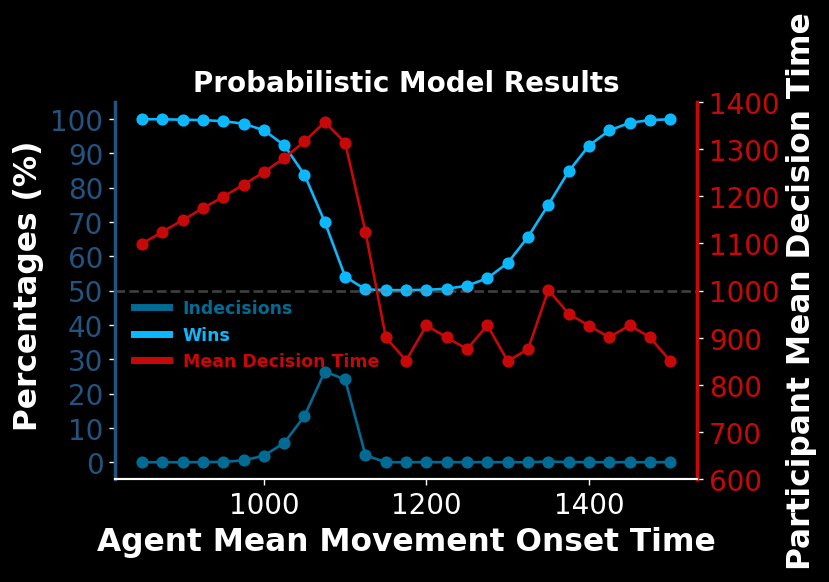

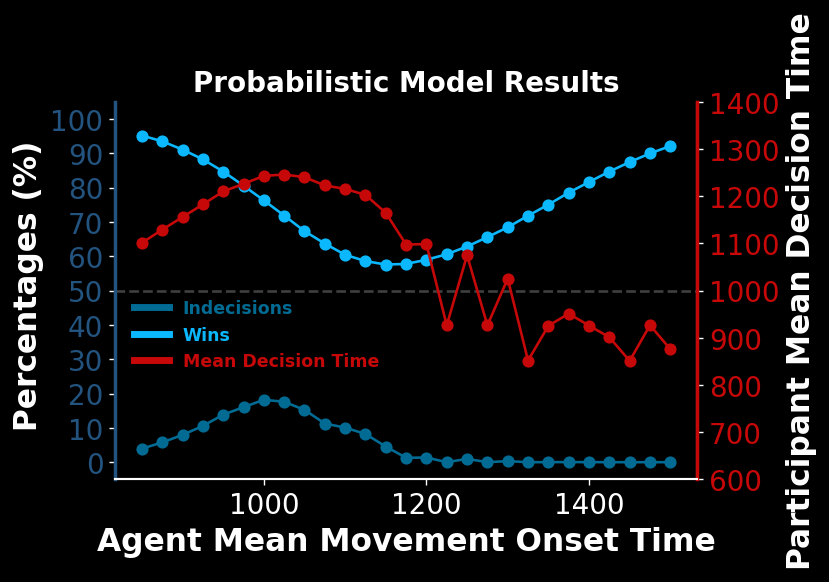

In [95]:

p1_std = np.arange(30,210,10)
p2_std = np.arange(50,425,25)
p1_std = [mean_variability_all_subs+20]
p2_std = [50,150]
for sig1 in (p1_std):
    for sig2 in p2_std:
        #%% Constant Variables
        TRIAL_TIME = 1500
        NUM_TRIALS = 100000
        REACTION_TIME = mean_reaction_time_all_subs - 40
        MOVEMENT_TIME = mean_movement_time_all_subs
        AGENT_MOVEMENT_TIME = 150
        #Start and end decision time for player 1
        interval = 25
        start_time1 = 1000
        end_time1 = 1650
        total_times1 = int((end_time1 - start_time1) / interval)+1
        target_reach_means_p1 = np.zeros(total_times1)
        # Start and end decision time for player 2
        start_time = 1000
        end_time = 1650
        total_times2 = int((end_time - start_time) / interval)+1
        target_reach_means_p2 = np.zeros(total_times2)
        # Creating AVERAGE decision time arrays
        # To be used in the norm.rvs
        for i in range(total_times1):
            target_reach_means_p1[i] = start_time1
            start_time1 = start_time1 + interval
        for i in range(total_times2):
            target_reach_means_p2[i] = start_time
            start_time = start_time + interval
        target_reach_means_p1 = target_reach_means_p1.astype(int)
        target_reach_means_p2 = target_reach_means_p2.astype(int)
        #Decision time storage arrays
        p1_reach_time = np.zeros((len(target_reach_means_p1), len(target_reach_means_p2),NUM_TRIALS))
        p2_reach_time = np.zeros((len(target_reach_means_p1), len(target_reach_means_p2),NUM_TRIALS))
        p1_decision_array = np.zeros((len(target_reach_means_p1), len(target_reach_means_p2),NUM_TRIALS))
        p2_decision_array = np.zeros((len(target_reach_means_p1), len(target_reach_means_p2),NUM_TRIALS))
        p1_both_decided_array = np.zeros((len(target_reach_means_p1), len(target_reach_means_p2),NUM_TRIALS))
        p2_both_decided_array = np.zeros((len(target_reach_means_p1), len(target_reach_means_p2),NUM_TRIALS))

        #%% Run Simulation w/ SD = 100,100
        
        c=-1
        for dt_p1 in (target_reach_means_p1):
            c=c+1
            z=-1
            for dt_p2 in target_reach_means_p2:
                z=z+1
                # p1_reach_time[c,z,:] = skewnorm.rvs(-3, dt_p1, 100, size = NUM_TRIALS)
                # p2_reach_time[c,z,:] = skewnorm.rvs(-3, dt_p2, 100, size = NUM_TRIALS)
                p1_reach_time[c,z,:] = norm.rvs(dt_p1, sig1, size = NUM_TRIALS)
                p2_reach_time[c,z,:] = norm.rvs(dt_p2, sig2, size = NUM_TRIALS)
        p1_decision_time = p1_reach_time - MOVEMENT_TIME
        p2_decision_time = p2_reach_time - AGENT_MOVEMENT_TIME # Agent reaches in 300ms


        #make response time arrays
        # for dt_p1 in tqdm(target_reach_means_p1):
        #         c=c+1
        #         z=-1
        #         for dt_p2 in target_reach_means_p2:
        #             z=z+1

        #-----------------------------------------------------------------------------
        p1_wins, p2_wins, p1_indecision, p2_indecision, \
            p1_reach_time, p2_reach_time, p1_decision_time, p2_decision_time, p1_decision_array, p2_decision_array, \
                p1_both_decided_array, p2_both_decided_array = Simulate_Wins_Only_P1_Sensory_Feedback(TRIAL_TIME, NUM_TRIALS, REACTION_TIME,MOVEMENT_TIME,
                                                                                                      target_reach_means_p1, target_reach_means_p2, 
                                                                                                      p1_reach_time, p2_reach_time,
                                                                                                      p1_decision_time,p2_decision_time)
        # Calculate both decided wins
        p1_perc_both_decided_wins, p2_perc_both_decided_wins = \
            calc_both_decide_wins(NUM_TRIALS,target_reach_means_p1, target_reach_means_p2, 
                                p1_decision_array, p2_decision_array, 
                                p1_both_decided_array,
                                p2_both_decided_array)
        # Caluclate mean decision times
        
        #%% Find optimal control policy 
        # Find average of actual decision times
        p1_avg_dt = np.zeros((len(target_reach_means_p1), len(target_reach_means_p2)))
        p1_avg_dt_final = np.zeros(len(target_reach_means_p1))
        for i in range(len(target_reach_means_p1)):
            for j in range(len(target_reach_means_p2)):
                p1_avg_dt[i,j] = np.mean(p1_decision_time[i,j,:])
        for i in range(len(target_reach_means_p1)):
            p1_avg_dt_final[i] = np.mean(p1_avg_dt[i,:])  
            
        optimal_mean_decision_time = np.zeros(len(target_reach_means_p1))
        optimal_indecisions = np.zeros(len(target_reach_means_p1))
        optimal_wins = np.zeros(len(target_reach_means_p1))
        perc_optimal_both_decided_wins = np.zeros(len(target_reach_means_p1))
        for j in range(len(target_reach_means_p2)):
            max_win_index = np.argmax(p1_wins[:,j])
            optimal_mean_decision_time[j] = p1_avg_dt[max_win_index,j]
            optimal_indecisions[j] = p1_indecision[max_win_index,j]
            optimal_wins[j] = p1_wins[max_win_index,j]
            perc_optimal_both_decided_wins[j] = p1_perc_both_decided_wins[max_win_index,j]
        perc_optimal_wins = optimal_wins/NUM_TRIALS*100
        perc_optimal_indecisions = optimal_indecisions/NUM_TRIALS*100


        ## GET OPTIMALS FOR THE EXPERIMENT CONDITIONS AND STORE IN LIST
        decision_means_p2 = target_reach_means_p2 - AGENT_MOVEMENT_TIME
        condition_indices = np.where((decision_means_p2 == 1000) | (decision_means_p2 == 1100) | (decision_means_p2 == 1200))
        if sig2 == 150:
            optimal_wins_150_list = perc_optimal_wins[condition_indices]
            optimal_indecisions_150_list = perc_optimal_indecisions[condition_indices]
            optimal_decision_time_150_list = optimal_mean_decision_time[condition_indices]
        if sig2 == 50:
            optimal_wins_50_list = perc_optimal_wins[condition_indices]
            optimal_indecisions_50_list = perc_optimal_indecisions[condition_indices]
            optimal_decision_time_50_list = optimal_mean_decision_time[condition_indices]


        ## PLOT ------------------------------------------------------------------------------------------------
        #%% All on one, with vertical lines on the selected mean decision time
        plt.figure(dpi=125)
        ax = plt.subplot()
        ax.plot(target_reach_means_p2-AGENT_MOVEMENT_TIME,perc_optimal_indecisions,'-o', c = wheel.dark_blue2, label = 'Indecisions')
        ax.plot(target_reach_means_p2-AGENT_MOVEMENT_TIME,perc_optimal_wins,'-o', c = wheel.light_blue, label = 'Wins')
        #ax.plot(target_reach_means_p2-AGENT_MOVEMENT_TIME,perc_optimal_both_decided_wins,'-o', c = wheel.blue , label = 'Wins')
        ax.axhline(y=50, c = 'grey', linestyle = '--', alpha = 0.5)
        # ax.axvline(x = 1000, ymin = 0, ymax = optimal_wins[0], color = 'black')
        # ax.axvline(x = 1200, ymin = 0, ymax = optimal_wins[7], color = 'black',zorder = 0)
        ax.set_ylim(-5,105)
        ax.set_yticks(np.arange(0,110,10), np.arange(0,110,10), c = wheel.dark_blue)
        ax.set_xlabel("Agent Mean Movement Onset Time")
        ax.set_ylabel(' Percentages (%)')
        ax.spines['left'].set_color(wheel.dark_blue)
        ax.spines['left'].set_linewidth(2)
        ax.spines['top'].set_visible(False)

        ax2 = ax.twinx()
        ax2.plot(target_reach_means_p2-AGENT_MOVEMENT_TIME,optimal_mean_decision_time,'-o', c=wheel.dark_red)
        ax2.set_yticks(np.arange(400,1600,100))
        ax2.set_yticklabels(np.arange(400,1600,100),c=wheel.dark_red)
        ax2.set_ylim(600,1400)
        ax2.spines['right'].set_visible(True)
        ax2.spines['right'].set_color(wheel.dark_red)
        ax2.spines['right'].set_linewidth(2)
        ax2.set_ylabel('Participant Mean Decision Time')
        ax2.spines['left'].set_visible(False)
        ax2.spines['top'].set_visible(False)
        #ax.set_title(f'P1 SD = {sig1}, P2 SD = {sig2}')
        ax.set_title('Probabilistic Model Results')
        labels = ['Indecisions', 'Wins','Mean Decision Time']
        colors = [wheel.dark_blue2,wheel.light_blue,wheel.dark_red]
        dv.Custom_Legend(ax, labels, colors, loc=(0.02,0.27), fontsize = 10)
        #plt.savefig(PATH+f'\\numerical_optimal_wins_indecisions_decision_time_sd1_{sig1}_sd2_{sig2}_rt_{REACTION_TIME}_mt_{MOVEMENT_TIME}_amt_{AGENT_MOVEMENT_TIME}', dpi = 400, transparent = True, bbox_inches='tight')
        plt.show()
        #plot_list.append(ax)

In [96]:
# Combine 50 and 150 lists to fit nicely within
optimal_wins_list = []
optimal_indecisions_list = []
optimal_decision_time_list = []

a,b = -1,-1
for i in range(6):
    if i%2 == 0:
        a+=1
        optimal_wins_list.append(optimal_wins_50_list[a])
        optimal_indecisions_list.append(optimal_indecisions_50_list[a])
        optimal_decision_time_list.append(optimal_decision_time_50_list[a])
    else:
        b+=1
        optimal_wins_list.append(optimal_wins_150_list[a])
        optimal_indecisions_list.append(optimal_indecisions_150_list[a])
        optimal_decision_time_list.append(optimal_decision_time_150_list[a])
        


In [97]:
optimal_wins_list

[96.733, 76.289, 54.089, 60.443000000000005, 50.251999999999995, 58.992]

# Plots

In [98]:

dot_color = 'black'
plt.style.use('cashaback_dark')
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)

Decision Times boxplot

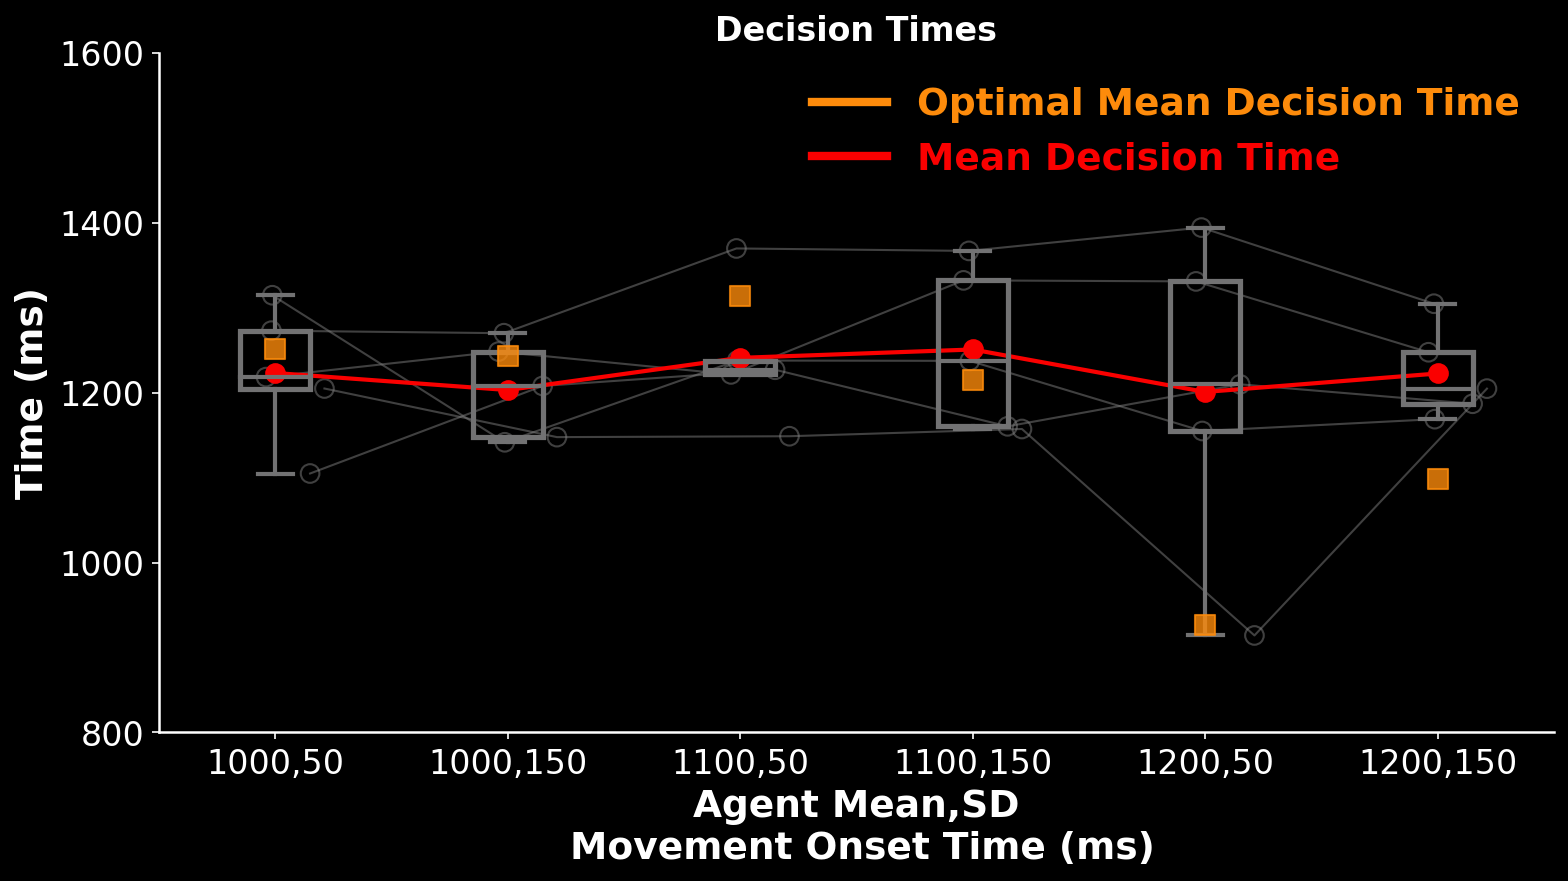

In [106]:
xlocs = np.arange(0, num_blocks)
ylocs = np.arange(400,1800,200)
colors = [wheel.seth_red, wheel.dark_grey,wheel.rak_orange]
plt.figure(dpi=150, figsize = (12,6))
ax=plt.subplot()

dv.jitter_array(ax,xlocs,player_mean_decision_time.T,0.1, mean_color = colors[0], mean_edge_color = colors[0],circle_size = 80, circle_lw = 1,lw = 1, circle_alpha = 0.5, include_mean = True, zorder = 22 )
boxplot(player_mean_decision_time, box_widths=0.05, box_color1 = colors[1],xlocs = xlocs, ylocs= ylocs, xlab = "Agent Mean,SD\n Movement Onset Time (ms)",
        ylab='Time (ms)', title='Decision Times')
ax.scatter(xlocs, optimal_decision_time_list, c = colors[2], marker = 's', s = 100, zorder = 20, alpha = 0.8)

ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylim(800,1600)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
dv.Custom_Legend(ax,['Optimal Mean Decision Time','Mean Decision Time'],[wheel.rak_orange,wheel.seth_red], fontsize = 18)
plt.savefig(save_path+'decision_times_boxplots_with_model_optimals', dpi = 400, transparent = True, bbox_inches='tight')
plt.show()

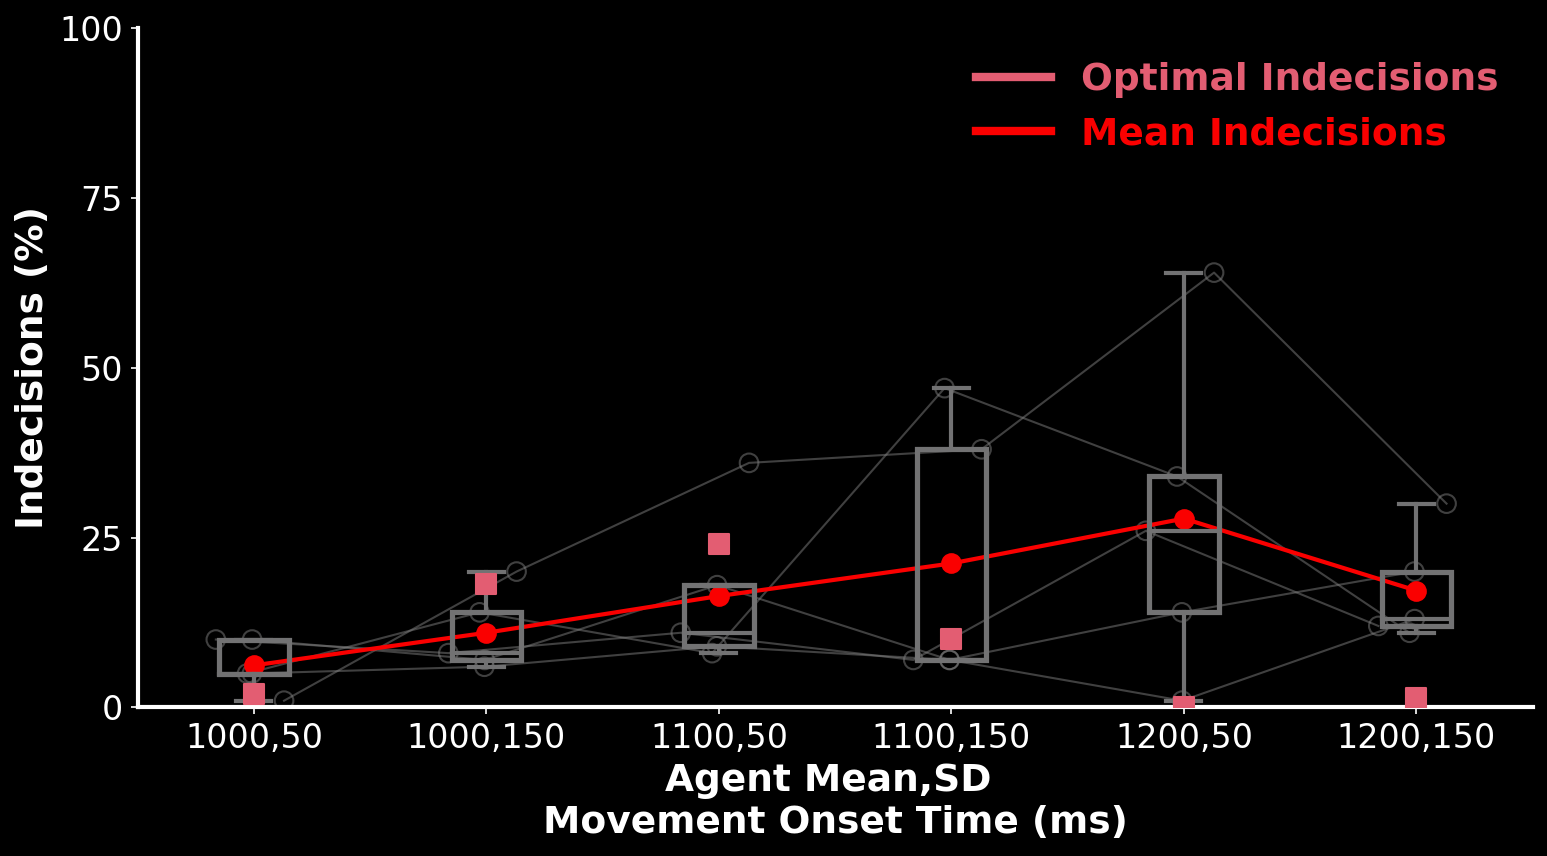

In [107]:
xlocs = np.arange(0, num_blocks)
ylocs = np.arange(0,125,25)
colors = [wheel.seth_red, wheel.rak_red,wheel.dark_grey]
plt.figure(dpi=150, figsize=(12,6))
ax=plt.subplot()
boxplot(perc_player_indecisions, box_widths = 0.05, box_color1 = colors[2],xlocs=xlocs, ylocs=ylocs, xlab = "Agent Mean,SD \nMovement Onset Time (ms)",
       ylab='Indecisions (%)', title=None)
#ax.plot(jitter(xlocs, perc_player_indecisions).T,perc_player_indecisions.T, marker = 'o',markerfacecolor = dot_color, markeredgecolor = '0.6', color='0.3', alpha = 0.8,zorder=1 )
dv.jitter_array(ax,xlocs,perc_player_indecisions.T,0.1, mean_color = colors[0], mean_edge_color = colors[0], circle_size = 80, circle_lw = 1,lw = 1, circle_alpha = 0.5, include_mean = True )
ax.scatter(xlocs,optimal_indecisions_list,marker = 's', s = 100,c=colors[1], zorder = 20)
ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylim(0,100)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
dv.Custom_Legend(ax,['Optimal Indecisions','Mean Indecisions'],[colors[1],colors[0]], fontsize = 18)
plt.savefig(save_path+'indecision_boxplots_with_model_optimals', dpi = 400, transparent = True, bbox_inches='tight')
plt.show()

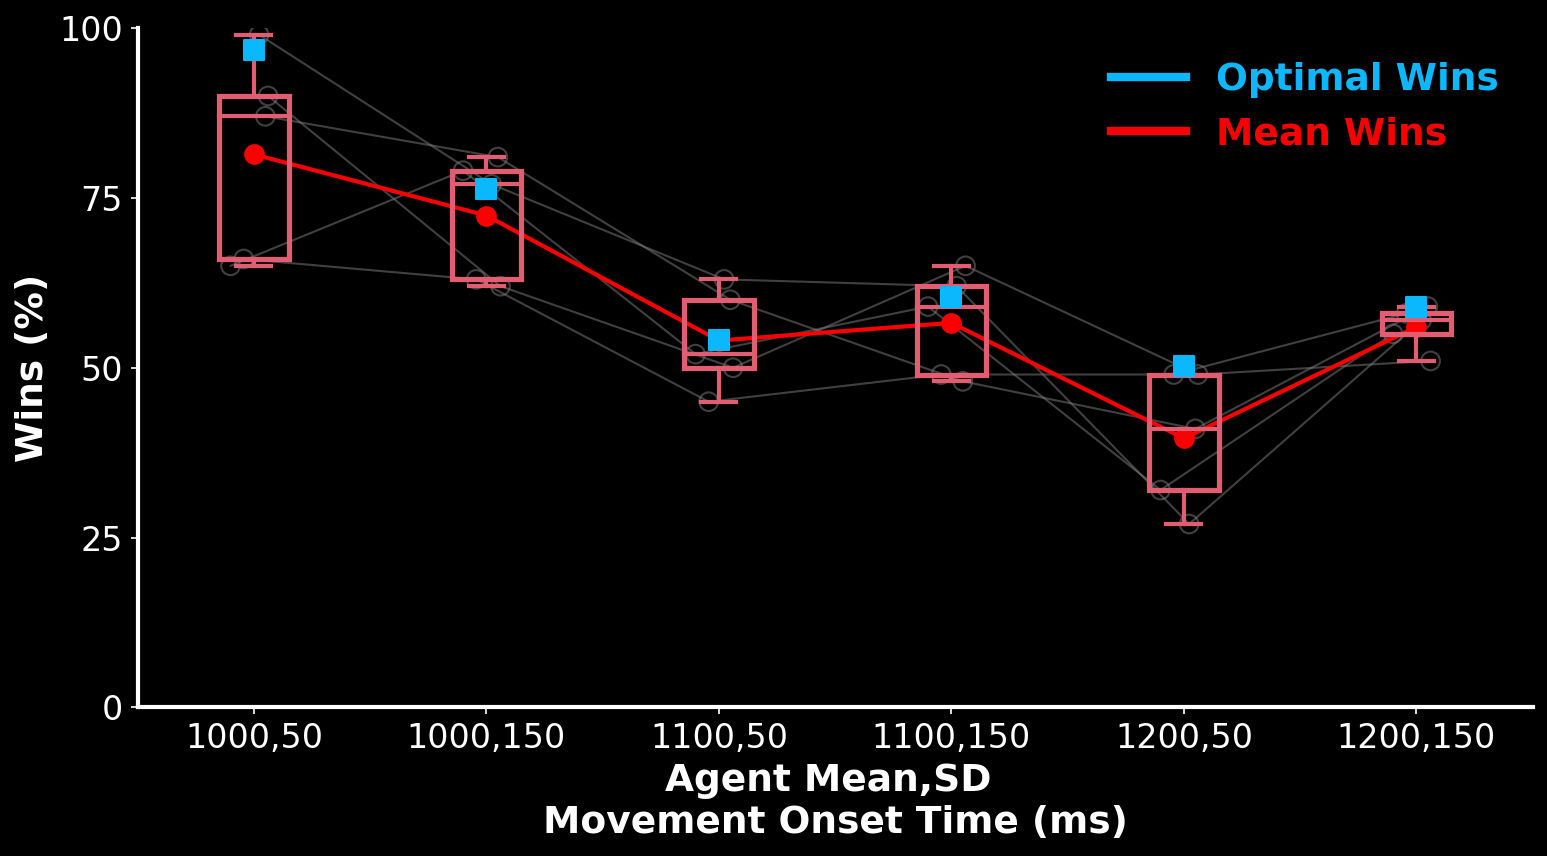

In [108]:
xlocs = np.arange(0, num_blocks)
ylocs = np.arange(0,125,25)

plt.figure(dpi=150, figsize=(12,6))
ax=plt.subplot()
boxplot(perc_player_wins, box_widths = 0.05, xlocs=xlocs, ylocs=ylocs, xlab = "Agent Mean,SD \nMovement Onset Time (ms)",
       ylab='Wins (%)', title=None)
dv.jitter_array(ax,xlocs,perc_player_wins.T,0.1, mean_color = colors[0],mean_edge_color = colors[0],circle_size = 80, circle_lw = 1,lw = 1, circle_alpha = 0.5, include_mean = True )
ax.scatter(xlocs,optimal_wins_list, marker = 's', s = 100,c=wheel.rak_blue, zorder = 20)
ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylim(0,100)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
dv.Custom_Legend(ax,['Optimal Wins','Mean Wins'],[wheel.rak_blue,wheel.seth_red], fontsize = 18)
plt.savefig(save_path+'wins_boxplots_with_model_optimals', dpi = 400, transparent = True, bbox_inches='tight')
plt.show()

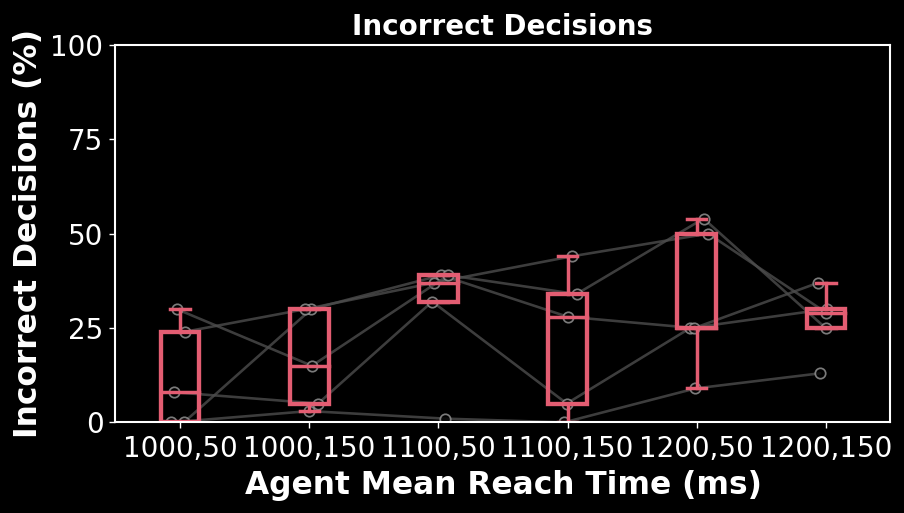

In [66]:
xlocs = np.arange(0, num_blocks)
ylocs = np.arange(0,125,25)
plt.figure(dpi=125, figsize=(8,4))
ax=plt.subplot()
boxplot(perc_player_incorrect_decisions, box_widths = 0.05,xlocs=xlocs, ylocs=ylocs, xlab = "Agent Mean Reach Time (ms)",
        ylab='Incorrect Decisions (%)', title='Incorrect Decisions')
ax.plot(jitter(xlocs, perc_player_incorrect_decisions).T,perc_player_incorrect_decisions.T, marker = 'o',markerfacecolor = dot_color, markeredgecolor = '0.6', color='0.3', alpha = 0.8,zorder=1 )
ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylim(0,100)
plt.savefig(save_path+'incorrect_decisions_boxplots', dpi = 400, transparent = True, bbox_inches='tight')
plt.show()

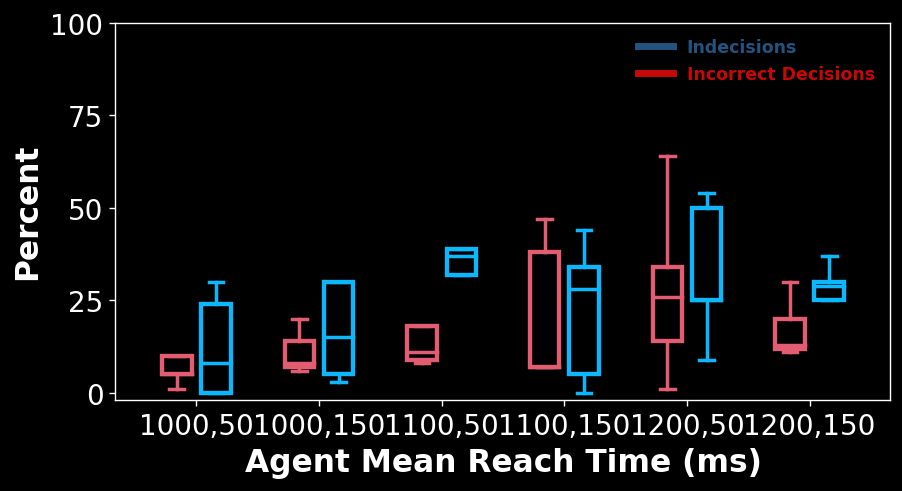

In [ ]:
#%% Incorrect decisions and indecisions boxplot together
xlocs = np.arange(0, num_blocks)
ylocs = np.arange(0,110,25)
box_width = 0.04
plt.figure(dpi=125, figsize=(8,4))
ax=plt.subplot()
boxplot(perc_player_indecisions, xlocs=xlocs, ylocs=ylocs, box_widths = box_width, shift_box = True, shift_direction = -1, legend_labels = ['Indecisions', "Incorrect Decisions"], xlab = "Agent Mean Reach Time (ms)",
        ylab='Incorrect Decisions (%)', title='Incorrect Decisions')
#ax.plot(jitter((xlocs-box_width*4), perc_player_indecisions).T,perc_player_indecisions.T, marker = 'o',markerfacecolor = dot_color, markeredgecolor = '0.6', color='0.3', alpha = 0.8,zorder=1 )

boxplot(perc_player_incorrect_decisions, xlocs, ylocs, box_widths = box_width, shift_box = True, shift_direction = 1, legend_labels = ['Indecisions', "Incorrect Decisions"],xlab = "Agent Mean Reach Time (ms)",
        ylab='Percent', title='')
#ax.plot(jitter((xlocs+box_width*4), perc_player_incorrect_decisions).T,perc_player_incorrect_decisions.T, marker = 'o',markerfacecolor = dot_color, markeredgecolor = '0.6', color='0.3', alpha = 0.8,zorder=1 )
ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylim(-2,100)
plt.savefig(PATH+save_path+'indecisions_incorrect_decisions_boxplots_no_dots', dpi = 400, transparent = True, bbox_inches='tight')
plt.show()